# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Learning Objectives

At the end of the experiment, you will be able to:

1.   Understand why we are performing Transfer Learning
2.   Understand role of the Fine tuning 
3.   Classify ants and bees 

In [0]:
#@title Experiment Explanation Video
from IPython.display import HTML

HTML("""<video width="800" height="300" controls>
  <source src="https://cdn.talentsprint.com/talentsprint/archives/sc/aiml/aiml_2018_blr_b6/cfus/week_11/module_3_week_11_experiment_5.mp4" type="video/mp4">
</video>
""")

## Dataset

### Description

 For this experiment we have choosen a dataset which is subset of Imagenet. We have taken images belonging to ants and bees. The dataset contains 120 training images and 75 validation images for each class. 

![alt text]( https://cdn.talentsprint.com/aiml/Experiment_related_data/IMAGES/15.png)



## AI/ML Technique

### Transfer Learning

Transfer learning makes use of the knowledge gained while solving one problem and applying it to a different but related problem. 

Let us try to understand above statement using an example. If we train a neural network to identify backpack in an image, the same network can also be used to identify sunglasses in the image. In early layers the model has learned to recognize the object, just we need to train the latter layers so, that it can recognize the sunglasses from other objects.

We will be using transfer learning in two cases :

1. When we don’t have enough labeled training data to train your network from scratch
2. When there already exists a network that is pre-trained on a similar task, which is usually trained on massive amounts of data.

### Fine Tuning

Fine tuning is a process to take a network model that has already been trained for a given task, and make it perform a new similar task by tweaking the parameters of the trained model.

In this experiment we will train a model to identify ants in an image, then we fine tune the trained model by tweaking its parameters to identify bees in an image.

#### Keywords

* Finetuning
* Transfer learning
* Learning rate scheduler
* CrossentropyLoss
* Stochastic gradient descent optimizer

### Expected time to complete this experiment is : 90min

### Setup Steps

In [0]:
#@title Please enter your registration id to start: (e.g. P181900101) { run: "auto", display-mode: "form" }
Id = "P181902118" #@param {type:"string"}


In [0]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "8860303743" #@param {type:"string"}


In [0]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython

ipython = get_ipython()
  
notebook="BLR_M3W1E32_TransferLearning_FineTuning" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")
    ipython.magic("sx pip3 install torch")
    ipython.magic("sx pip3 install torchvision")
    ipython.magic("sx pip install Pillow==4.0.0")
    ipython.magic("sx wget https://cdn.talentsprint.com/aiml/Experiment_related_data/week9/Exp5/hymenoptera_data.zip")
    ipython.magic("sx unzip hymenoptera_data.zip")
    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    
    ipython.magic("notebook -e "+ notebook + ".ipynb")
    
    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:        
        print(r["err"])
        return None        
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getAnswer() and getComplexity() and getAdditional() and getConcepts():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional, 
              "concepts" : Concepts, "record_id" : submission_id, 
              "answer" : Answer, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook}

      r = requests.post(url, data = data)
      r = json.loads(r.text)
      print("Your submission is successful.")
      print("Ref Id:", submission_id)
      print("Date of submission: ", r["date"])
      print("Time of submission: ", r["time"])
      print("View your submissions: https://iiith-aiml.talentsprint.com/notebook_submissions")
      print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
      return submission_id
    else: submission_id
    

def getAdditional():
  try:
    if Additional: return Additional      
    else: raise NameError('')
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None
  
def getConcepts():
  try:
    return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None

def getAnswer():
  try:
    return Answer
  except NameError:
    print ("Please answer Question")
    return None

def getId():
  try: 
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup 
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
    from IPython.display import HTML
    HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id))
  
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


#### Importing the required packages

Before diving into experiments let us try to understand some basic pytorch packages :

**torchvision :** This package is used to load and prepare the dataset. Using this package we can perform / apply transformations on the input data.  

**transforms :** This package is  used to perform preprocessing on images and operations sequentially. 

**nn :**  This package provides an easy and modular way to build and train simple or complex neural networks.

**optim:** This package is used for  implementing various optimization algorithms


In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

#### Loading the dataset

Most of the neural network algorithms expect the images of fixed size as input so we need to apply transformations on images like rescaling the image, flipping the image horizontaly or vertically e.t.c

In [0]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
len(dataloaders['val'])*4

156

#### Visualization of training images

To get sense of how data looks. Let us plot random training images belonging to each class. As the images are stored in the form of tensor, we will convert them to numpy array then we try to plot the images

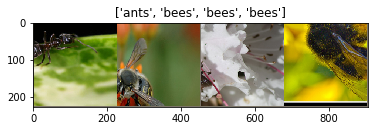

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.grid(False)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### Training a model

Let us write a general function to trained the model. Here we will see :

1. Scheduling the learning rate
2. Saving the best model

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Function to visualizing the model predictions

Here we will write a generic function to visualize the predicted images along with the labels.

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



#### Finetuning the model
Loading a pretrained model and reseting final fully connected layer.

ResNet is a short name for Residual Network. resnet18 contains 18 layers in which the last layer is chopped and a linear layer is added which is used to identify the bees images from ant images. 

In [0]:
model_ft = models.resnet18(pretrained=True) # load the pretrained architecture
num_ftrs = model_ft.fc.in_features # pick the last layer [fully connected]
model_ft.fc = nn.Linear(num_ftrs, 2) #replaced the last layer with layer in which output classes are two.

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) #model_ft.parameters() is passed to update all the weights, thats why it is called fine tuning [not only the final layer weights]

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 27670643.24it/s]


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
train Loss: 0.5581 Acc: 0.7213
val Loss: 0.1866 Acc: 0.9281

Epoch 1/1
----------
train Loss: 0.5289 Acc: 0.7910
val Loss: 0.2489 Acc: 0.9216

Training complete in 0m 7s
Best val Acc: 0.928105


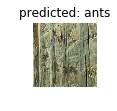

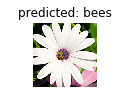

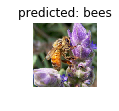

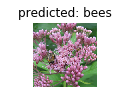

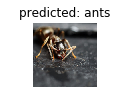

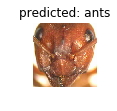

In [0]:
visualize_model(model_ft)

### Please answer the questions below to complete the experiment:




In [0]:
#@title The final layers are retrained usually if the pre-trained model's domain is closer to the current problem's domain? { run: "auto", form-width: "500px", display-mode: "form" }
Answer = "True" #@param ["True', "False"]


In [0]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging me" #@param ["Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging me", "Was Tough, but I did it", "Too Difficult for me"]


In [0]:
#@title If it was very easy, what more you would have liked to have been added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = " Felt good" #@param {type:"string"}

In [0]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["Yes", "No"]

In [0]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id =return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 5225
Date of submission:  22 May 2019
Time of submission:  17:26:05
View your submissions: https://iiith-aiml.talentsprint.com/notebook_submissions
For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.
